# Prédiction du genre d'une personne à partir de sa photo

auteur : Umut Şimşekli & Alexandre Gramfort, challenge SD210 2017

L'objectif est de prédire le genre d'une personne (homme ou femme) à partir de caractéristiques extraites d'une photo.

Les données sont fournies par la société Morpho: http://www.morpho.com/fr

Le fichier que doit fournir chacun est un fichier au format .txt de 8496 lignes::

    1
    0
    -1
    1
    ...

où chaque ligne contient la prédiction. Contrairement à un problème de classification binaire où y=1 ou y=-1, vous avez la possibilité de prédire 0, ce qui signifie que vous ne savez pas. Il y a 8496 images dans l'ensemble de validation.


### Critère de performance 

Vous pouvez donc répondre pour chaque image : homme (y=1), femme (y=-1) ou je-ne-sais-pas (y=0).

Se tromper coûte 10 points et ne pas savoir coûte 1 point. Mathématiquement, le score est calculé de la façon suivante:
 
$score = \frac1{N} \sum_{i=1}^N \Bigl(\mathbb{1}(\hat{y}_i = 0) + 10 \times \mathbb{1}(y_i \hat{y}_i = -1)   \Bigr) $ 

où $\mathbb{1}(\cdot)$ est la fonction indicatrice; $\mathbb{1}(x) = 1$ si $x$ est vrai, et $\mathbb{1}(x) = 0$, sinon.

Plus ce nombre est petit mieux c'est.


# Données d'apprentissage: 

https://www.dropbox.com/s/dqudxed82ljnxa8/training_templates.csv

https://www.dropbox.com/s/l0f9z08rysp0kjy/training_labels.txt


# Données de validation:

https://www.dropbox.com/s/syrry7miykrmjz0/testing_templates.csv

Voyons cela par l'exemple:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Critere de performance
def compute_pred_score(y_true, y_pred):
    y_pred_unq =  np.unique(y_pred)
    for i in y_pred_unq:
        if((i != -1) & (i!= 1) & (i!= 0) ):
            raise ValueError('The predictions can contain only -1, 1, or 0!')
    y_comp = y_true * y_pred
    score = float(10*np.sum(y_comp == -1) + np.sum(y_comp == 0))
    score /= y_comp.shape[0]
    return score

In [3]:
X_train_fname = 'training_templates.csv'
y_train_fname = 'training_labels.txt'
X_test_fname  = 'testing_templates.csv'
X_train = pd.read_csv(X_train_fname, sep=',', header=None).values
X_test  = pd.read_csv(X_test_fname,  sep=',', header=None).values
y_train = np.loadtxt(y_train_fname, dtype=np.int)

## Investigation des données

In [4]:
X_train.shape, X_test.shape, y_train.shape

((105600, 128), (8496, 128), (105600,))

In [5]:
print('n_samples : %d, n_features : %d' % X_train.shape)

n_samples : 105600, n_features : 128


In [6]:
np.mean(y_train), np.unique(y_train)

(0.0, array([-1,  1]))

In [7]:
#from sklearn.preprocessing import StandardScaler
#X_scaler = StandardScaler()
#X_train = X_scaler.fit_transform(X_train)
#X_test = X_scaler.transform(X_test)

## Exemple de classification

Voyons maintenant un exemple de classification et de production d'un fichier de soumission

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

param_grid = {"n_estimators":[100,500,1000],
              "learning_rate":[0.1, 1, 10]
}

clf = AdaBoostClassifier(random_state=42)
gs = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

gs.best_estimator_

/cal/softs/anaconda/anaconda-2.0.1/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/cal/softs/anaconda/anaconda-2.0.1/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=1000, random_state=42)

In [9]:
# Prediction
y_pred_train =  gs.best_estimator_.predict(X_train)
y_predict_train_proba = gs.best_estimator_.predict_proba(X_train)[:,0]
        
for i in range(len(y_pred_train)):
    if (y_predict_train_proba[i]<0.9)and(y_predict_train_proba[i]>1-0.9):
        y_pred_train[i]=0

# score
score = compute_pred_score(y_train, y_pred_train)
print('Score sur le train : %s' % score)

Score sur le train : 1.0


Génération de la prédiction sur le test et enregistrement du fichier à soumettre sur le site:

In [13]:
print y_predict_train_proba.max(), y_predict_train_proba.min()

0.505320855335 0.494753982859


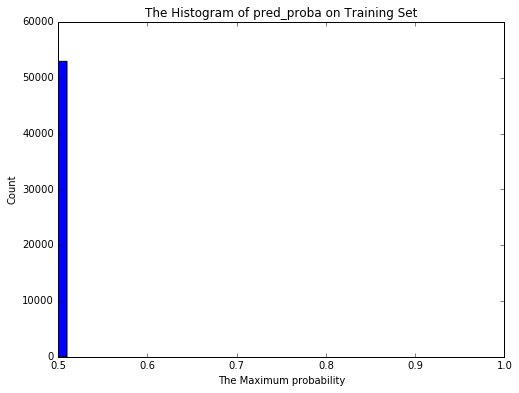

In [12]:
bins = np.arange(0.5, 1.0, 0.01)
plt.figure(1, figsize=(8,6))
plt.hist(y_predict_train_proba, bins=bins)
plt.title('The Histogram of pred_proba on Training Set')
plt.xlim(0.5, 1)
plt.xlabel('The Maximum probability')
plt.ylabel('Count')
plt.show()

In [14]:
y_pred = gs.best_estimator_.predict(X_test)
#y_predict_proba = gs.best_estimator_.predict_proba(X_test)[:,0]

#for i in range(len(y_pred)):
#    if (y_predict_proba[i]<0.9)and(y_predict_proba[i]>1-0.9):
#        y_pred[i]=0
#print np.unique(y_pred)

np.savetxt('y_pred_ada.txt', y_pred, fmt='%d')

In [15]:
print y_pred.sum()

2620


Vous pouvez maintenant uploader votre fichier `y_pred.txt` sur le site.

Bonne chance !